In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 00-01-04 ~ 21-02-05 입니다
# Yahoo Finanace에서 다운로드 받습니다 
# null값과 0값을 제거한 데이터를 사용합니다


df = pd.read_csv('C:\Jupyter_Project\Hanyang_Securities_63_21_21.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-03,8990,9010,8830,8840,8840,50420
1,2020-09-04,8770,8770,8620,8680,8680,50024
2,2020-09-07,8680,8860,8680,8740,8740,37808
3,2020-09-08,8840,8840,8700,8720,8720,27257
4,2020-09-09,8700,8700,8570,8600,8600,42491


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
100,2021-02-01,9200,9480,9100,9380,9380,81355
101,2021-02-02,9460,9810,9460,9700,9700,105755
102,2021-02-03,9850,10200,9800,9990,9990,170966
103,2021-02-04,10100,10200,9940,10150,10150,133504
104,2021-02-05,10200,10800,10150,10650,10650,251300


In [4]:
# OHLC를 Adj OHLC로 바꾸기 위한 비율입니다
# Adj OHLC는 과거의 절대가격을 현재 가격의 시점으로 보기위한 수정된 가격입니다
# 과거 발생한 액면분할과 현금배당을 반영한 Adj Close를 기준으로 조정합니다

ratio = df['Adj Close']/df['Close']
ratio

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
100    1.0
101    1.0
102    1.0
103    1.0
104    1.0
Length: 105, dtype: float64

In [5]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [6]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [7]:
df.rename(columns={'Adj Open':'Open', 'Adj High':'High', 'Adj Low':'Low', 'Adj Close':'Close'}, inplace=True)

In [8]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,8990.0,9010.0,8830.0,8840,50420
1,8770.0,8770.0,8620.0,8680,50024
2,8680.0,8860.0,8680.0,8740,37808
3,8840.0,8840.0,8700.0,8720,27257
4,8700.0,8700.0,8570.0,8600,42491
...,...,...,...,...,...
100,9200.0,9480.0,9100.0,9380,81355
101,9460.0,9810.0,9460.0,9700,105755
102,9850.0,10200.0,9800.0,9990,170966
103,10100.0,10200.0,9940.0,10150,133504


In [9]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

         Open      High       Low     Close    Volume
0    0.357447  0.303502  0.368421  0.278884  0.079970
1    0.263830  0.210117  0.267943  0.215139  0.079232
2    0.225532  0.245136  0.296651  0.239044  0.056462
3    0.293617  0.237354  0.306220  0.231076  0.036795
4    0.234043  0.182879  0.244019  0.183267  0.065191
..        ...       ...       ...       ...       ...
100  0.446809  0.486381  0.497608  0.494024  0.137632
101  0.557447  0.614786  0.669856  0.621514  0.183113
102  0.723404  0.766537  0.832536  0.737052  0.304665
103  0.829787  0.766537  0.899522  0.800797  0.234837
104  0.872340  1.000000  1.000000  1.000000  0.454405

[105 rows x 5 columns]


In [10]:
# 20일 학습하고 그 다음날 종가예측
# 테스트 기간은 21일, 따라서 5299-21 : train / 21 : test

window_size = 20
TEST_SIZE = 21

In [11]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [12]:
# 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어준다

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train set : 모델을 학습하는 유일한 dataset
# validation set : 학습이 이미 완료된 모델을 검증하기 위한 dataset(비율 0.2) 

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.25)

x_train.shape, x_valid.shape
# ((4206, 20, 4), (1052, 20, 4))

# test dataset : 학습과 검증이 완료된 모델의 성능을 평가하기 위한 dataset
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape
#     (21, 4),          (21, 1)  

((21, 4), (21, 1))

In [14]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)

test_feature.shape, test_label.shape
# (21-20, 20, 4),     (21-20, 1)

((1, 20, 4), (1, 1))

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(20, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [16]:
# val_loss가 10회 같을 시 early_stop, batch_size(=K)는 K문제 풀고 답보고 하는 식
# 위에서 모델을 구성한 후 compile 메서드를 호출하여 학습과정을 설정합니다
# optimizer : 훈련 과정을 설정한다
# loss : 최적화 과정에서 최소화될 손실 함수(loss function)을 설정합니다
# metrics : 훈련을 모니터링하기 위해 사용됩니다
# validation_data = 검증 데이터를 사용합니다. 각 에포크마다 정확도도 함께 출력됩니다
# 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증데이터를 학습하지는 않습니다
# 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 overfitting의 신호입니다
# verbose / 0 : 출력 없음 / 1 : 훈련 진행도 보여주는 진행 막대 보여줌 / 2 : 미니 배치마다 손실 정보 출력

from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
    
    
model.compile(loss = RMSE, optimizer='adam', metrics=[soft_acc])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

score = model.evaluate(test_feature, test_label, batch_size=16)
score_val = model.evaluate(x_valid, y_valid, batch_size=16)

print('train loss, train acc : ' + str(score))
print('validation loss, validation acc : ' + str(score_val))

Epoch 1/200
3/3 [==============================] - 6s 2s/step - loss: 0.6359 - soft_acc: 0.3854 - val_loss: 0.5047 - val_soft_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.50475, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 2/200
3/3 [==============================] - 0s 116ms/step - loss: 0.5786 - soft_acc: 0.4323 - val_loss: 0.4745 - val_soft_acc: 0.6875

Epoch 00002: val_loss improved from 0.50475 to 0.47453, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 3/200
3/3 [==============================] - 0s 41ms/step - loss: 0.5390 - soft_acc: 0.3932 - val_loss: 0.4421 - val_soft_acc: 0.6875

Epoch 00003: val_loss improved from 0.47453 to 0.44212, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 4/200
3/3 [==============================] - 0s 58ms/step - loss: 0.5034 - soft_acc: 0.3854 - val_loss

3/3 [==============================] - 0s 32ms/step - loss: 0.0562 - soft_acc: 0.9583 - val_loss: 0.0722 - val_soft_acc: 0.6875

Epoch 00033: val_loss did not improve from 0.07155
Epoch 34/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0724 - soft_acc: 0.8958 - val_loss: 0.0722 - val_soft_acc: 0.6875

Epoch 00034: val_loss did not improve from 0.07155
Epoch 35/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0721 - soft_acc: 0.9193 - val_loss: 0.0722 - val_soft_acc: 0.6875

Epoch 00035: val_loss did not improve from 0.07155
Epoch 36/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0730 - soft_acc: 0.8802 - val_loss: 0.0721 - val_soft_acc: 0.6875

Epoch 00036: val_loss did not improve from 0.07155
1/1 [==============================] - 0s 33ms/step - loss: 0.0721 - soft_acc: 0.6875
train loss, train acc : [0.23190724849700928, 1.0]
validation loss, validation acc : [0.07208909839391708, 0.6875]


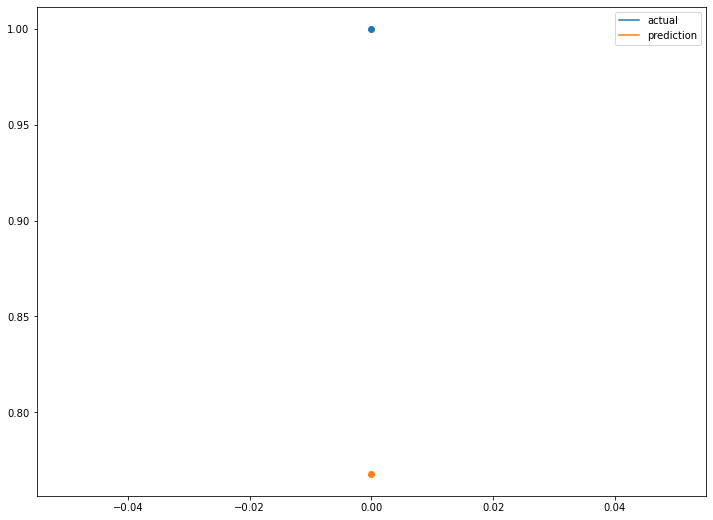

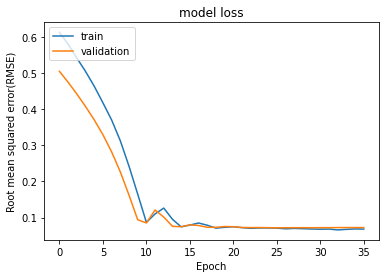

In [17]:
pred = model.predict(test_feature)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(test_label), label='actual')
plt.plot(pred, label='prediction')
x_values = list(range(1))
plt.scatter(x_values, np.asarray(test_label))
plt.scatter(x_values, pred)
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Root mean squared error(RMSE)')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
tf = test_feature[:,19]
tf

array([[0.82978723, 0.76653696, 0.89952153, 0.23483657]])

In [19]:
# scaler.inverse_transform(v)를 돌리기 위해 pred가 들어간 (1,5)를 만들어줍니다 
# tf는 형식 때문에 들어갔기 때문에 중요하게 취급되는 값이 아닙니다

arr_1D = np.insert(tf, 3, pred)

# scaler.inverse_transform(v)를 돌리기 위해 array를 2D로 바꿔줍니다

arr_2D = arr_1D.reshape((1,-1))

arr_2D

array([[0.82978723, 0.76653696, 0.89952153, 0.76809275, 0.23483657]])

In [20]:
sit_arr_2D = scaler.inverse_transform(arr_2D)
sit_arr_2D

array([[ 10100.        ,  10200.        ,   9940.        ,
         10067.91280627, 133504.        ]])

In [21]:
predict_HY = sit_arr_2D[:,3]

predict_HY

array([10067.91280627])

In [22]:
# 21일 중 20일을 학습시켜 얻은 21-02-05의 예측주가입니다(2/5 종가 확정 후 검사)

prediction = int(predict_HY[[0]])
print('Predicted value for next day=',prediction, '원')
b = df['Close'].iloc[-1]
print('Last close price=',b, '원')
percentage = ((prediction-b)/b)*100
print('percentage change should be =', percentage.round(3),'%' )

Predicted value for next day= 10067 원
Last close price= 10650 원
percentage change should be = -5.474 %


In [23]:
# count : 개수, std : 표준편차

test[label_cols].describe()

,Close
count,21.000000
mean,0.631948
std,0.148987
min,0.446215
25%,0.533865
50%,0.609562
75%,0.737052
max,1.000000


In [24]:
Y = np.asarray(test_label)
Y_hat = pred
RMSE = np.sqrt(np.mean((Y_hat-Y)**2))
print(len(Y), Y.shape[0])





print('[RMSE]')
print('train_loss = ' + str(score[0]))
print('valid_loss = ' + str(score_val[0]))
print("test_loss  =",RMSE)

1 1
[RMSE]
train_loss = 0.23190724849700928
valid_loss = 0.07208909839391708
test_loss  = 0.23190724849700883


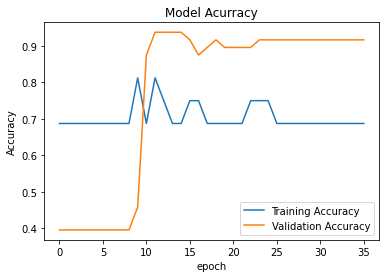

In [25]:
plt.plot(history.history['val_soft_acc'])
plt.plot(history.history['soft_acc'])
plt.title('Model Acurracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()